In [1]:
import pandas as pd
df = pd.read_csv("edf_forecasting/data/03_primary/eco2mix/definitive/cleaned_consumption_data.csv")

In [2]:
import pandas as pd
import numpy as np
from typing import Tuple

class DataPreparator:
    """
    Prépare les données pour l'entraînement : tri temporel, vérification fréquence,
    split temporel (train/cal/test) et création des fenêtres glissantes.
    """
    def __init__(self, df: pd.DataFrame, datetime_col: str = "Datetime", target_col: str = "Consommation", freq: str = "30min"):
        self.raw_df = df.copy()
        self.datetime_col = datetime_col
        self.target_col = target_col
        self.freq = freq

        # Objets accessibles après run()
        self.df_prepared = None
        self.df_train = None
        self.df_cal = None
        self.df_test = None
        self.X_train, self.y_train = None, None
        self.X_cal, self.y_cal = None, None
        self.X_test, self.y_test = None, None

    def prepare_datetime(self):
        df = self.raw_df.copy()
        df[self.datetime_col] = pd.to_datetime(df[self.datetime_col])
        df = df.sort_values(self.datetime_col).set_index(self.datetime_col)

        inferred_freq = pd.infer_freq(df.index)
        if inferred_freq != self.freq:
            raise ValueError(f"Inconsistent frequency: expected {self.freq}, got {inferred_freq}")

        self.df_prepared = df

    def split_by_year(self, cal_year: int = 2021, test_year: int = 2022):
        df = self.df_prepared
        self.df_train = df[df.index.year < cal_year]
        self.df_cal = df[df.index.year == cal_year]
        self.df_test = df[df.index.year == test_year]

    def create_windows(self, window_size: int = 48):
        def create_X_y(df):
            values = df[self.target_col].values
            X, y = [], []
            for i in range(window_size, len(values)):
                X.append(values[i - window_size:i])
                y.append(values[i])
            return np.array(X), np.array(y)

        self.X_train, self.y_train = create_X_y(self.df_train)
        self.X_cal, self.y_cal = create_X_y(self.df_cal)
        self.X_test, self.y_test = create_X_y(self.df_test)

    def run(self, cal_year=2021, test_year=2022, window_size=48):
        self.prepare_datetime()
        self.split_by_year(cal_year=cal_year, test_year=test_year)
        self.create_windows(window_size=window_size)

In [3]:
prep = DataPreparator(df)
prep.run()

prep.X_train, prep.y_train
prep.X_cal, prep.y_cal
prep.X_test, prep.y_test

(array([[54615., 54015., 52108., ..., 52396., 54428., 53885.],
        [54015., 52108., 52239., ..., 54428., 53885., 53707.],
        [52108., 52239., 51803., ..., 53885., 53707., 52442.],
        ...,
        [49627., 51102., 50375., ..., 46519., 45855., 45083.],
        [51102., 50375., 49941., ..., 45855., 45083., 45796.],
        [50375., 49941., 48806., ..., 45083., 45796., 47688.]]),
 array([53707., 52442., 50317., ..., 45796., 47688., 47519.]))

In [4]:
import os
import yaml
import datetime
import optuna
import logging
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

logging.basicConfig(level=logging.INFO)

class XGBoostTuner:
    def __init__(self, n_trials=20, cv=3, timeout=None, seed=42, study_dir="optuna_studies"):
        self.n_trials = n_trials
        self.cv = cv
        self.timeout = timeout
        self.seed = seed
        self.study_dir = study_dir

    def run(self, X, y):
        timestamp = datetime.datetime.now().strftime("tuning_%Y-%m-%d_%H-%M")
        base_dir = os.path.join(self.study_dir, timestamp)
        os.makedirs(base_dir, exist_ok=True)

        study_path = os.path.join(base_dir, "optuna_study.db")
        params_path = os.path.join(base_dir, "best_params.yml")

        study = optuna.create_study(
            direction="minimize",
            study_name="xgb_tuning",
            storage=f"sqlite:///{study_path}",
            load_if_exists=True
        )

        def objective(trial):
            params = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 80),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
                "gamma": trial.suggest_float("gamma", 0.0, 5.0),
                "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
                "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
                "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
                "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
                "n_jobs": -1,
                "random_state": self.seed
            }

            model = XGBRegressor(**params)
            scores = cross_val_score(model, X, y, cv=self.cv, scoring="neg_root_mean_squared_error", n_jobs=-1)
            return -scores.mean()

        study.optimize(objective, n_trials=self.n_trials, timeout=self.timeout, show_progress_bar=True)

        best_params = study.best_params
        best_score = study.best_value

        summary = {
            "study_path": study_path,
            "best_score_rmse": best_score,
            "best_params": best_params,
            "n_trials": self.n_trials,
            "cv": self.cv,
            "seed": self.seed,
            "timestamp": timestamp
        }

        with open(params_path, "w") as f:
            yaml.dump(summary, f)

        logging.info(f"Tuning terminé. Résultats sauvegardés dans : {params_path}")
        return best_params, study

In [5]:
tuner = XGBoostTuner(n_trials=50, cv=3, seed=123)
best_params, study = tuner.run(prep.X_train, prep.y_train)

[I 2025-05-14 09:14:12,875] A new study created in RDB with name: xgb_tuning


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-14 09:14:25,495] Trial 0 finished with value: 6283.436422281007 and parameters: {'n_estimators': 60, 'max_depth': 8, 'learning_rate': 0.010738952588654227, 'subsample': 0.6291798029204339, 'colsample_bytree': 0.7391330565246861, 'colsample_bynode': 0.7863494480158528, 'gamma': 1.16657650749028, 'reg_alpha': 1.8203566779421169e-06, 'reg_lambda': 5.059214491360636e-06, 'min_child_weight': 2, 'booster': 'dart'}. Best is trial 0 with value: 6283.436422281007.
[I 2025-05-14 09:14:27,836] Trial 1 finished with value: 6461.239326798975 and parameters: {'n_estimators': 57, 'max_depth': 5, 'learning_rate': 0.01108955156978332, 'subsample': 0.5147809230224973, 'colsample_bytree': 0.5683208917497571, 'colsample_bynode': 0.9766629588510918, 'gamma': 2.245308446669876, 'reg_alpha': 2.517641165592443e-06, 'reg_lambda': 0.00029553380779036276, 'min_child_weight': 14, 'booster': 'gbtree'}. Best is trial 0 with value: 6283.436422281007.
[I 2025-05-14 09:14:38,590] Trial 2 finished with value

INFO:root:Tuning terminé. Résultats sauvegardés dans : optuna_studies/tuning_2025-05-14_09-14/best_params.yml


[I 2025-05-14 09:19:40,968] Trial 49 finished with value: 542.4178841712325 and parameters: {'n_estimators': 80, 'max_depth': 10, 'learning_rate': 0.07706600285548126, 'subsample': 0.8606923031378757, 'colsample_bytree': 0.8883139980013173, 'colsample_bynode': 0.6312620628888945, 'gamma': 2.821808985869729, 'reg_alpha': 6.586605167545764e-07, 'reg_lambda': 9.51227574012117, 'min_child_weight': 14, 'booster': 'gbtree'}. Best is trial 41 with value: 496.24898004757125.


In [6]:
from xgboost import XGBRegressor
from sklearn.base import clone

class XGBTrainer:
    def __init__(self, model_params: dict):
        self.model_params = model_params
        self.model = XGBRegressor(**self.model_params)
        self.is_fitted = False

    def fit(self, X, y):
        self.model.fit(X, y)
        self.is_fitted = True
        return self.model  # retour explicite du modèle entraîné

    def get_model(self):
        if not self.is_fitted:
            raise RuntimeError("Le modèle n'a pas encore été entraîné.")
        return self.model

In [8]:
trainer = XGBTrainer(best_params)
model = trainer.fit(prep.X_train, prep.y_train)

In [9]:
import numpy as np

class XGBCalibrator:
    def __init__(self, model, error_type="raw"):
        """
        Initialise le calibrateur à partir d’un modèle entraîné.
        error_type : "raw" ou "absolute"
        """
        self.model = model
        self.error_type = error_type
        self.q_inf = None
        self.q_sup = None

    def fit(self, X_cal, y_cal, alpha=0.05):
        """
        Calibre les bornes d’intervalle de confiance à partir des erreurs sur le set de calibration.
        """
        y_pred = self.model.predict(X_cal)
        errors = y_cal - y_pred

        if self.error_type == "absolute":
            errors = np.abs(errors)

        self.q_inf = np.quantile(errors, alpha / 2)
        self.q_sup = np.quantile(errors, 1 - alpha / 2)

    def predict(self, X):
        """
        Renvoie les prédictions et les intervalles calibrés (lower, upper).
        """
        y_pred = self.model.predict(X)
        lower = y_pred + self.q_inf
        upper = y_pred + self.q_sup

        return y_pred, lower, upper

In [11]:
calibrator = XGBCalibrator(model)
calibrator.fit(prep.X_cal, prep.y_cal, alpha=0.05)
y_pred, lower, upper = calibrator.predict(prep.X_test)

In [12]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error

def pinball_loss(y_true, y_pred, quantile):
    delta = y_true - y_pred
    return np.mean(np.maximum(quantile * delta, (quantile - 1) * delta))

def evaluate_predictions(y_true, y_pred, lower, upper, quantile=0.95):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    lower = np.array(lower)
    upper = np.array(upper)

    coverage = np.mean((y_true >= lower) & (y_true <= upper))
    interval_width = np.mean(upper - lower)

    pll = pinball_loss(y_true, lower, quantile=quantile / 2)
    plu = pinball_loss(y_true, upper, quantile=1 - quantile / 2)

    return {
        "rmse": root_mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "coverage": coverage,
        "interval_width": interval_width,
        "pinball_loss_lower": pll,
        "pinball_loss_upper": plu,
        "overflow_rate": np.mean(y_true > upper)
    }

In [13]:
# Évaluation
scores = evaluate_predictions(prep.y_test, y_pred, lower, upper, quantile=0.95)

# Impression propre
for k, v in scores.items():
    print(f"{k}: {v:.4f}")

rmse: 481.6754
mae: 351.5291
r2: 0.9982
coverage: 0.9416
interval_width: 1902.4330
pinball_loss_lower: 454.4497
pinball_loss_upper: 468.3095
overflow_rate: 0.0271


In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random

class XGBVisualizer:
    def __init__(self, model):
        """
        Initialize with a trained XGBRegressor model.
        """
        self.model = model
        self._check_fitted()

    def _check_fitted(self):
        if not hasattr(self.model, "n_features_in_"):
            raise ValueError("Model must be fitted before visualization.")

    def infer_sequence(self, start_sequence, horizon=48):
        """
        Perform autoregressive inference over a given horizon.
        """
        window_size = len(start_sequence)
        if window_size != self.model.n_features_in_:
            raise ValueError(f"Expected input length {self.model.n_features_in_}, got {window_size}.")

        sequence = list(start_sequence.copy())
        preds = []

        for _ in range(horizon):
            input_window = np.array(sequence[-window_size:]).reshape(1, -1)
            pred = self.model.predict(input_window)
            preds.append(pred[0])
            sequence.append(pred[0])

        return np.array(preds)

    def plot_autoregressive_samples(self, X_test, y_test, horizon=48, n_samples=5, seed=None):
        """
        Plot autoregressive predictions vs ground truth for random test samples.
        """
        if seed is not None:
            random.seed(seed)

        max_index = len(X_test) - horizon
        indices = random.sample(range(max_index), k=n_samples)

        for i, idx in enumerate(indices):
            x_start = X_test[idx]
            y_true = y_test[idx:idx + horizon]
            y_pred = self.infer_sequence(x_start, horizon=horizon)

            plt.figure(figsize=(10, 4))
            plt.plot(y_true, label="True", linewidth=2)
            plt.plot(y_pred, label="Predicted", linestyle="--", linewidth=2)
            plt.title(f"Sample {i+1}: Autoregressive Prediction vs True")
            plt.xlabel("Horizon step")
            plt.ylabel("Target value")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

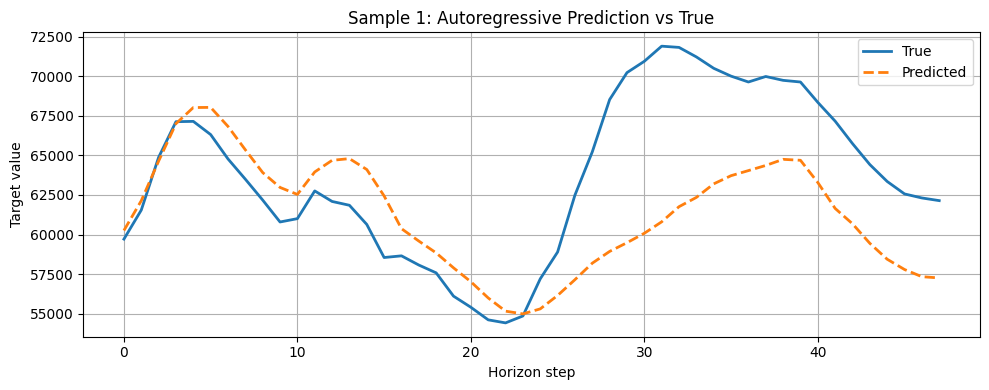

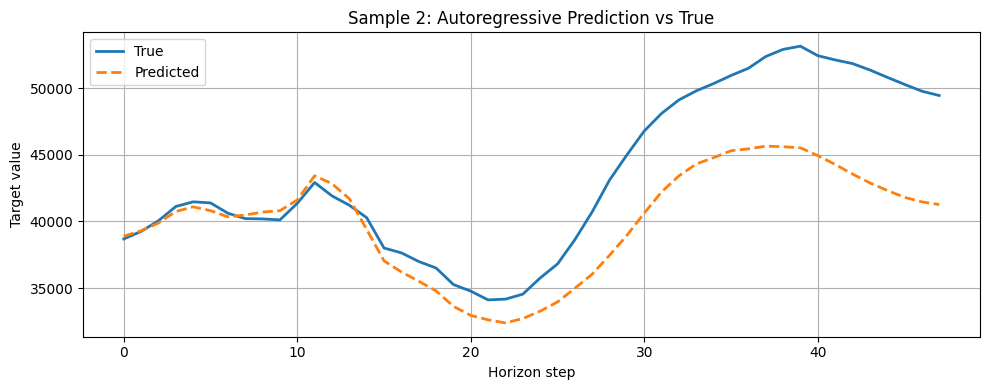

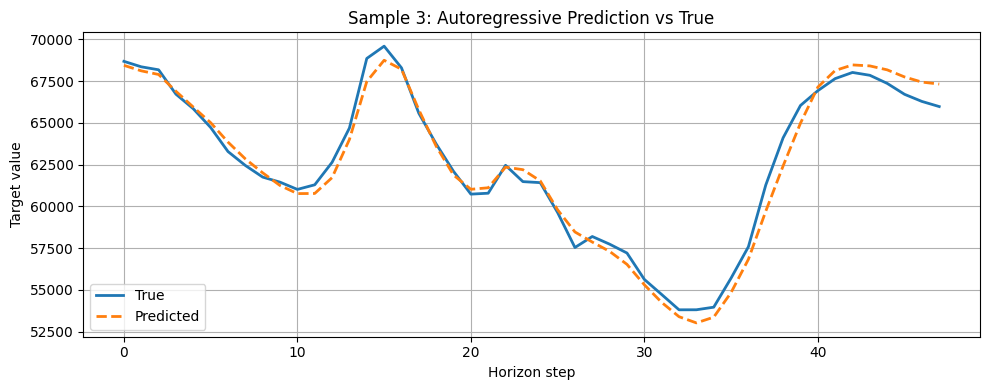

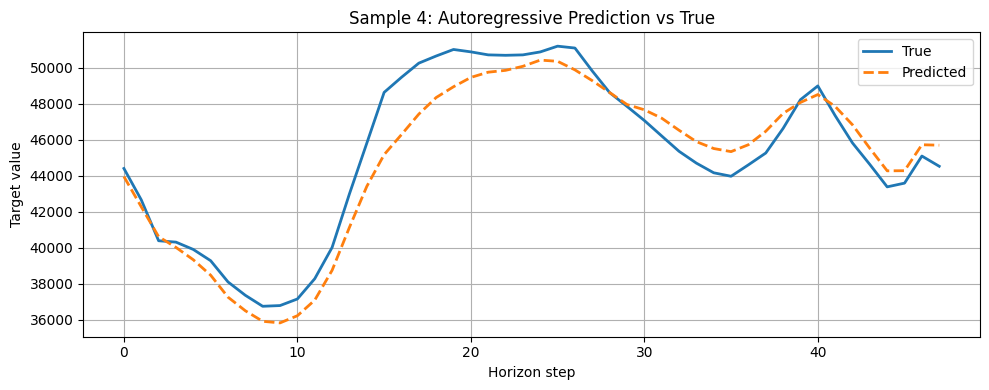

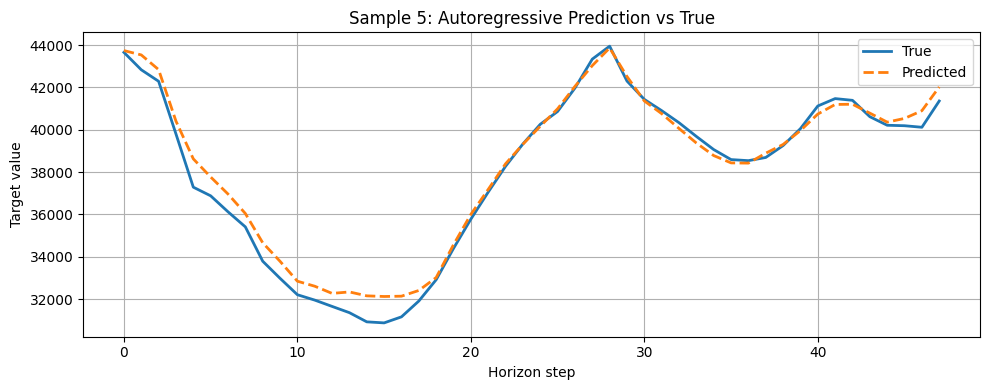

In [17]:
visualizer = XGBVisualizer(model)
visualizer.plot_autoregressive_samples(prep.X_test, prep.y_test, n_samples=5, seed=123)